In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import json

with open('podcast.txt', 'rb') as f:
    request = json.load(f)

In [13]:
import networkx as nx
import community
import math
import logging

In [37]:
from numpy import dot
from numpy.linalg import norm
from boto3 import client as boto3_client
import json
from botocore.client import Config
import numpy as np


config = Config(connect_timeout=240, read_timeout=240, retries={'max_attempts': 0}, )
lambda_client = boto3_client('lambda', config=config)

def preprocess_text(text):
    mod_texts_unfiltered = tp.preprocess(text, stop_words=False, remove_punct=False)
    mod_texts = []

    for index, sent in enumerate(mod_texts_unfiltered):
        if len(sent.split(' ')) > 250:
            length = len(sent.split(' '))
            split1 = ' '.join([i for i in sent.split(' ')[:round(length / 2)]])
            split2 = ' '.join([i for i in sent.split(' ')[round(length / 2):]])
            mod_texts.append(split1)
            mod_texts.append(split2)
            continue

        if len(sent.split(' ')) <= 6:
            continue

        mod_texts.append(sent)
    return mod_texts

def cosine(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))


def get_feature_vector(mind_input, lambda_function):
    invoke_response = lambda_client.invoke(FunctionName=lambda_function, InvocationType='RequestResponse', Payload=mind_input)
    # logger.info("computing feature vector", extra={"msg": "Request Sent"})
    out_json = invoke_response['Payload'].read().decode('utf8').replace("'", '"')
    data = json.loads(json.loads(out_json)['body'])
    response = json.loads(out_json)['statusCode']

    if response == 200:
        feature_vector = data['sent_feats'][0]

        # logger.info("computing feature vector", extra={"msg": "Response Recieved"})
    else:
        logger.error("Invalid response from  mind service")
        print(response)
        # logger.error("computing feature vector", extra={"msg": "Invalid response from  mind service"})
    return feature_vector

def compute_feature_vector_gpt(sentences, lambda_function):
        graph_list = {}
        input_list = []
        fv = {}
        index = 0
        for segment in sentences:
            for sent in segment['originalText']:
                if sent != '':
                    input_list.append(sent)
                    
        mind_input = json.dumps({"text": input_list})
        mind_input = json.dumps({"body": mind_input})
        transcript_score = get_feature_vector(mind_input, lambda_function)
        for segment in self.segments_list:
            for sent in segment['originalText']:
                if sent != '':
                    graph_list[index] = sent
                    fv[index] = transcript_score[index]
                    index += 1
        return fv, graph_list

def compute_feature_vector(sentences, lambda_function):
    graph_list = {}
    fv = {}
    index = 0
    all_segments = ""
    for segment in sentences:
        for sent in segment:
            if sent != '':
                if sent[-1] == ".":
                    all_segments = all_segments + " " + sent
                else:
                    all_segments = all_segments + " " + sent + ". "
    mind_input = json.dumps({"text": all_segments, "nsp": False})
    mind_input = json.dumps({"body": mind_input})
    transcript_score = get_feature_vector(mind_input, lambda_function)
    for segment in sentences:
        for sent in segment:
            if sent != '':
                graph_list[index] = sent
                fv[index] = transcript_score[index]
                index += 1
    return fv, graph_list


In [38]:
import sys
sys.path.append("../../../ai-engine/pkg/")
import text_preprocessing.preprocess as tp
seg_list = []
for seg in request['body']["segments"]:
    seg_list.append(seg)

In [39]:
sent_list = []
segments_text = list(map(lambda x: preprocess_text(x['originalText']), seg_list))

In [40]:
#lambda_function = "mind-" + request["body"]["mindId"]
lambda_function = "mind-" + "01daaqyn9gbebc92aywnxedp0c"
fv, graph_list = compute_feature_vector(segments_text, lambda_function)

In [117]:
def construct_graph(fv, graph_list):
    meeting_graph = nx.Graph()
    yetto_prune = []
    c_weight = 0
    for nodea in graph_list.keys():
        for nodeb in graph_list.keys():
            if nodeb > nodea:
                c_weight = 1 - cosine(fv[nodea], fv[nodeb])
                meeting_graph.add_edge(nodea, nodeb, weight=c_weight)
                yetto_prune.append((nodea, nodeb, c_weight))
    return meeting_graph, yetto_prune

def prune_edges(meeting_graph, graph_list, yetto_prune, v):
    yetto_prune = sorted(yetto_prune, key=lambda kv : kv[2], reverse=True)
    meeting_graph_pruned = nx.Graph()
    for nodea, nodeb, weight in yetto_prune:
        meeting_graph_pruned.add_nodes_from([nodea, nodeb])
        #if nodea in sent_cluster.keys() and nodeb in sent_cluster.keys() and sent_cluster[nodea]==sent_cluster[nodeb]:  #0
        #    meeting_graph_pruned.add_edge(nodea, nodeb) 
        #    for index,(a,b,c) in enumerate(yetto_prune):
        #        if a==nodea and b==nodeb:
        #            del yetto_prune[index]
        #            break                             #1
    #yetto_prune = yetto_prune[:math.ceil(len(yetto_prune) * v) + 1]
    #logger.info("pruning value", extra={"v is : ": v})
    print ("pruning value: ", v)
    q3 = np.percentile(weights, 75)
    for indexa, indexb, c_score in yetto_prune:
        if c_score >=q3:
            meeting_graph_pruned.add_edge(indexa, indexb)
    return meeting_graph_pruned

def compute_louvian_community(meeting_graph_pruned, community_set):
    # community_set = community.best_partition(meeting_graph_pruned)
    # modularity_score = community.modularity(community_set, meeting_graph_pruned)
    community_set_sorted = sorted(community_set.items(), key=lambda kv: kv[1], reverse=False)
    return community_set_sorted


In [118]:
meeting_graph, yetto_prune = construct_graph(fv, graph_list)
max_meeting_grap_pruned = None
max_community_set = None
max_mod = 0
for v in [0.15, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01]:
    # flag = False
    for count in range(5):
        meeting_graph_pruned = prune_edges(meeting_graph, graph_list, yetto_prune, v)
        community_set = community.best_partition(meeting_graph_pruned)
        mod = community.modularity(community_set, meeting_graph_pruned)
        #logger.info("Meeting Graph results", extra={"edges before prunning": meeting_graph.number_of_edges(), "edges after prunning": meeting_graph_pruned.number_of_edges(), "modularity ": mod})
        print("edges before prunning: ", meeting_graph.number_of_edges(), "edges after prunning: ", meeting_graph_pruned.number_of_edges(), "modularity: ", mod)
        # if mod>0.3:
        #     flag = True
        #     break
        # if mod==0:
        #     meeting_graph_pruned = self.prune_edges(meeting_graph, graph_list, yetto_prune, 0.15)
        #     flag = True
        #     break
        if mod > max_mod and mod <= 0.50:
            max_meeting_grap_pruned = meeting_graph_pruned
            max_community_set = community_set
            max_mod = mod
            # flag = True
            # if flag:
            #     break
meeting_graph_pruned = max_meeting_grap_pruned
community_set = max_community_set
mod = max_mod

#logger.info("Meeting Graph results", extra={"edges before prunning": meeting_graph.number_of_edges(), "edges after prunning": meeting_graph_pruned.number_of_edges(), "modularity": mod})
print("edges before prunning: ", meeting_graph.number_of_edges(), "edges after prunning: ", meeting_graph_pruned.number_of_edges(), "modularity: ", mod)
community_set_sorted = compute_louvian_community(meeting_graph_pruned, community_set)

pruning value:  0.15
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.12044871137015936
pruning value:  0.15
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.11099085273646513
pruning value:  0.15
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.11040296485789769
pruning value:  0.15
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.12084222244725827
pruning value:  0.15
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.10938792376351546
pruning value:  0.1
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.10548713477040768
pruning value:  0.1
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.11494363412576994
pruning value:  0.1
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.11604464957464786
pruning value:  0.1
edges before prunning:  4851 edges after prunning:  1213 modularity:  0.11244426109290054
pruni

In [120]:
current = 0
print ("--------------cluster " + str(0) + "------------ \n ")
for word, cluster in community_set_sorted:
    if cluster!=current:
        print ("--------------cluster " + str(cluster) + "------------ \n ")
        print (graph_list[word])
        current=cluster
    else:
        print (graph_list[word])

--------------cluster 0------------ 
 
Were at that last equal of forty.
You can ask a Json array for the data if you want to know how many likes as Facebook page had for the data contained Under The ChiLites.And all modern programming languages will be able to interpret.
Millie from dots way does calm and today.
I start with the user big question around this is what problems are they making once you can identify the problem, then you can begin to start working to towards the solution second is understanding the brain and how does the project you are are working on aligned with the branch mission and goal to summarize in this stage you wanna identify the problems facing the users as well as the core goals of the brand and see how they along as a designer you probably have a gun of asumptions about what the user wants or does not want but not challenging those asumptions channel.
It is time for another round of alysis, but this time you wanna to ask yourself in your team questions like 

In [44]:
clusters = []
temp = []
prev_com = 0
for index,(word,cluster) in enumerate(community_set_sorted):
    if prev_com==cluster:
        temp.append(word)
        #print (temp)
        if index==len(community_set_sorted)-1:
            clusters.append(temp)
    else:
        clusters.append(temp)
        temp = []
        prev_com = cluster
        temp.append(word)

In [45]:
import pickle

with open("se_mind_gpt.pkl","rb") as f:
    mind = pickle.load(f)

In [46]:
mind

,sentence,feature_vector
0,You can use this bundle while developing apps ...,"[-0.9664402008056641, -0.617825448513031, -0.1..."
1,This command should start all dependent proces...,"[-0.3077327013015747, -0.8727796673774719, -0...."
2,How that intention is implemented is valuable ...,"[-0.37808552384376526, -0.22319017350673676, -..."
3,The functions runtime handles hosting and scal...,"[-0.2646429240703583, -0.7706016898155212, -0...."
4,It supports backing up from all storage engines,"[-0.8539779186248779, -0.46422240138053894, -0..."
5,This is what controls things like ensuring tha...,"[-0.3847832977771759, -0.5448210835456848, -0...."
6,The application has more functionality worth e...,"[-0.8838599920272827, -0.5927866697311401, -0...."
7,The implementation of the framework is easier ...,"[-0.5155700445175171, -0.7353488206863403, -0...."
8,It is not a replacement of Java though it is d...,"[-0.8713192939758301, -0.4847404360771179, -0...."
9,These bring up the service in a known good sta...,"[-0.5870342254638672, -0.30073386430740356, -0..."


In [50]:
cluster_sent = {}
sent_cluster = {}
for group in clusters:
    for sent in group:
        closest_sent = 0
        closest_mind_score = 0
        closest_mind = None
        temp = 0
        for fv_mind_id in mind["feature_vector"].keys():
            temp = 1 - cosine(fv[sent], mind["feature_vector"][fv_mind_id])
            if temp > closest_mind_score:
                closest_mind = fv_mind_id
                closest_mind_score = temp
        if closest_mind not in cluster_sent.keys():
            cluster_sent[closest_mind] = []
        cluster_sent[closest_mind].append(sent)
        sent_cluster[sent] = closest_mind

In [48]:
cluster_sent

{0: [74, 56, 16, 27, 75, 17],
 8: [82,
  43,
  78,
  3,
  2,
  0,
  89,
  21,
  77,
  46,
  81,
  34,
  42,
  19,
  65,
  20,
  53,
  44,
  59,
  33,
  41,
  35,
  57,
  71,
  95,
  86,
  8,
  40,
  9,
  52,
  15,
  58,
  88,
  39,
  55,
  76,
  13,
  6,
  50,
  79,
  87,
  48,
  90,
  23],
 2: [91,
  97,
  32,
  45,
  22,
  98,
  47,
  68,
  31,
  14,
  49,
  11,
  94,
  80,
  73,
  83,
  70,
  7,
  51,
  96,
  37],
 9: [38, 29, 24, 66, 72, 4, 5, 69, 63, 61, 12, 28, 26, 93, 67, 85, 1],
 1: [54, 30, 25, 18, 36, 64, 92],
 3: [10, 60],
 7: [84]}

In [49]:
for cluster_id in cluster_sent.keys():
    print ("-------- cluster chosen -------",  mind["sentence"][cluster_id], "\n\n")
    for sent in cluster_sent[cluster_id]:
        print (graph_list[sent], "\n\n\n")

-------- cluster chosen ------- You can use this bundle while developing apps using command line or by configuring it using webpack 


Were at that last equal of forty. 



I start with the user big question around this is what problems are they making once you can identify the problem, then you can begin to start working to towards the solution second is understanding the brain and how does the project you are are working on aligned with the branch mission and goal to summarize in this stage you wanna identify the problems facing the users as well as the core goals of the brand and see how they along as a designer you probably have a gun of asumptions about what the user wants or does not want but not challenging those asumptions channel. 



It is time for another round of alysis, but this time you wanna to ask yourself in your team questions like where did our process go right where did we struggle how are losers responding to the product. 



Does you make a call from a client to a

In [78]:
weights = []
for nodea, nodeb , weight in meeting_graph.edges.data():
    weights.append(weight["weight"])

In [105]:
import statistics

print (statistics.stdev(weights))
print (statistics.pstdev(weights))
print (statistics.variance(weights))
print (statistics.pvariance(weights))
print (statistics.mean(weights))
print (statistics.mean(weights)+statistics.pstdev(weights))

0.11609846775831138
0.11608650069465455
0.013478854215827667
0.013476075643530032
0.37341929727047607
0.4895057979651306


(array([ 107.,  813., 1265., 1218.,  790.,  358.,  188.,   95.,   12.,
           5.]),
 array([0.1128398 , 0.1904241 , 0.2680084 , 0.34559271, 0.42317701,
        0.50076131, 0.57834561, 0.65592991, 0.73351421, 0.81109851,
        0.88868281]),
 <a list of 10 Patch objects>)

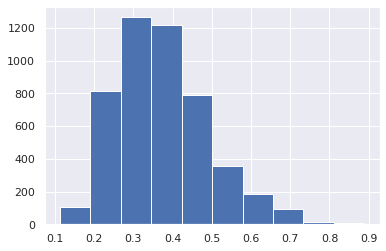

In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(color_codes=True)

matplotlib.pyplot.hist(weights)

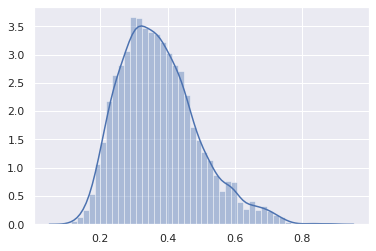

In [94]:
x = weights
sns.distplot(x);

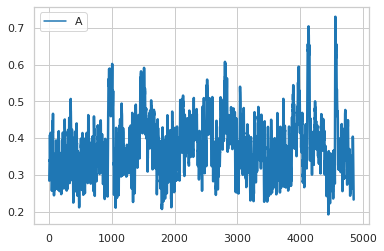

In [95]:
sns.set(style="whitegrid")

rs = np.random.RandomState(365)
values = weights
dates = list(range(len(weights)))
data = pd.DataFrame(values, dates, columns=["A"])
data = data.rolling(7).mean()

sns.lineplot(data=data, palette="tab10", linewidth=2.5)

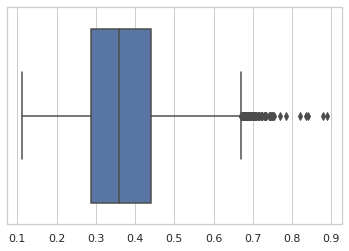

In [125]:
import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(x=weights)

In [116]:
np.percentile(weights, 75)

0.4410433725412034

In [139]:
np.quantile(weights, 1)

0.8886828139473822

In [140]:
max(weights)

0.8886828139473822

In [143]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

non_rejected = reject_outliers(np.asarray(weights))
len(non_rejected) - len(weights)

-813

In [146]:
min(non_rejected.tolist())

0.2080644484859434

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"I started seeing the code Recorder Server code on and we probably like by today I will start working on that issue let.")
displacy.serve(doc, style="dep")

/usr/lib64/python3.7/runpy.py:193: UserWarning:

[W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.




Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

